#類似画像アプリの中で使用している技術について説明します



---



#DINOv2

2021年GoogleはViTモデルを発表し、MetaはViTモデルと知識蒸留（Knowledge Distillation）※を組み合わせたDINOのオリジナル版を発表し同等の性能を持つ小型モデルを実現しました。
DINOv2においてMetaはより多くのトレーニングデータを収集し、トレーニングプロセスをスケールアップすることに注力しました。トレーニングデータとして、Metaはインターネットから12億枚の画像を収集し、ImageNetデータセットの画像との類似性に基づいてクラスタリングを行い、最終的に1億4200万枚の画像を収集しました。

※知識蒸留（Knowledge Distillation）とは、大規模で高精度な教師モデル（Teacher Model）が持つ「知識」を、より小さく軽量な生徒モデル（Student Model）に転送する手法です。これにより、生徒モデルは教師モデルほどのパフォーマンスを保ちながら、計算リソースや推論速度の面で効率化が図れる。



---



#ViT（Vision Transformer）の処理の流れ

1.  画像のパッチ分割とベクトル化
    <br>入力画像を固定サイズの小さなパッチに分割し、各パッチをフラット化した後、線形層などで固定次元のベクトル表現に変換します。


2. CLSトークンと位置エンコーディングの追加
    <br>さらに、全体の画像情報を集約するためのCLSトークンを先頭に追加し、各パッチベクトルに対して位置情報を付与する位置エンコーディングも加えます。

3. トランスフォーマーへの入力
    <br>こうして得られたパッチベクトルとCLSトークンを、自己注意機構を持つトランスフォーマーモジュールに入力します。トランスフォーマーは、各入力ベクトルが他のすべてのベクトルとの関係を学習することで、画像内の局所的および全体的な特徴を豊かに捉えます。

4.  CLSトークンの役割
    <br>トランスフォーマーの出力の中で、CLSトークンは画像全体の要約的な特徴を表現します。このCLSトークンの出力は、分類ヘッドなどに入力され、最終的に画像分類や他の下流タスクに利用されます。学習時には、損失を最小化するためにCLSトークンの表現が調整され、画像全体の特徴を正確に反映するようになります。


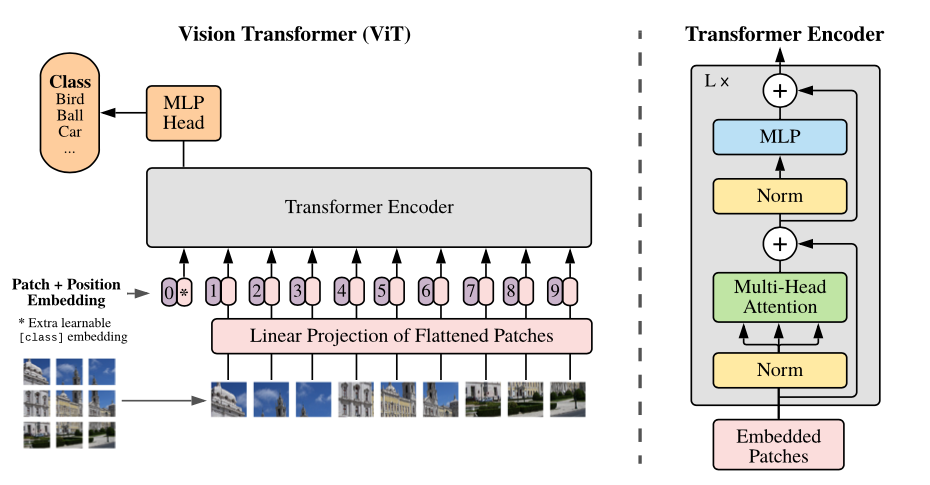

画像引用元 : https://github.com/google-research/vision_transformer



---



In [ ]:
from transformers import AutoImageProcessor, AutoModel

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')


In [ ]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
image_embedding = last_hidden_states[:, 0, :].squeeze(0)  # CLS トークンのみ取得




---



# ベクトルのコサイン類似度

**コサイン類似度**は、2つのベクトル間の方向の類似性を測る指標です。  
数値的には、以下の式で表されます。

$$
\text{cosine similarity}( \mathbf{a}, \mathbf{b} ) = \frac{\mathbf{a} \cdot \mathbf{b}}{\| \mathbf{a} \| \, \| \mathbf{b} \|}
$$
$$
ここで、
\mathbf{a} \cdot \mathbf{b} はベクトル \mathbf{a} と \mathbf{b} の内積です。
\|\mathbf{a}\| と \|\mathbf{b}\| は、それぞれのノルム（大きさ）です。
$$
この指標は、  
- **1** に近いほど2つのベクトルの方向が一致している（非常に似ている）ことを意味し、  
- **0** に近い場合は直交（無相関）であり、  
- **-1** に近い場合は逆方向（反対の意味）であることを示します。

例えば、画像の特徴抽出などで得られる高次元ベクトル同士の類似度を計算する際に、  
コサイン類似度を用いることで、**画像の類似性**を評価できます。

このように、コサイン類似度はベクトル表現が持つ方向性に注目し、  
絶対的な大きさの違いを無視して、各ベクトルの「向き」がどれだけ一致しているかを評価するために非常に有用です。


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity([image_embedding1.detach().numpy()], [image_embedding2.detach().numpy()])
print(f"Cosine Similarity: {similarity[0][0]}")



---



# Open Images V7 (Validation) データセット

**Open Images V7** は、Google が提供する大規模な画像データセットです。  
検証 (Validation) スプリットは、主にモデルの性能評価用として利用され、以下の特徴があります。

- **データ数**: 検証スプリットには約 41,620 枚の画像が含まれており、多様なシーンや被写体が収録されています。
- **カテゴリ数**: 600種類のオブジェクトクラスに対するラベルや、バウンディングボックス、セグメンテーションマスク、関係性の注釈が付与されています。
- **注釈情報**:  
  - 画像全体のラベル情報  
  - 各画像内の物体検出用のバウンディングボックス  
  - セグメンテーションマスク（オブジェクトの領域情報）  
  - 画像内のオブジェクト間の関係性情報
- **用途**:  
  - 画像分類、物体検出、セグメンテーションなど、さまざまなコンピュータビジョンタスクの研究と実践に広く利用されます。

このデータセットは、多様な画像データと豊富な注釈情報により、実世界の画像認識タスクに対して信頼性の高い検証データとして非常に有用です。今回は画像データのみを使用します。


[600種類のオブジェクトクラス](https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy_visualizer/circle.html)



---



#FiftyOne

FiftyOne は、画像データセットの管理、可視化、解析のためのオープンソースツール（ライブラリ）です。さまざまな画像データセット（COCO、ImageNet、VOC、Open Images など）を簡単にロードし、対話的に操作できるフレームワークとして提供されています。

In [ ]:
!pip install fiftyone

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz


dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    max_samples=9,
    shuffle=True,
    )


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v7/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv' to '/root/fiftyone/open-images-v7/validation/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v7/validation/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v6/oidv6-attributes-description.csv' to '/root/fiftyone/open-images-v7/validation/metadata/attributes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v7/validation/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v7/oidv7-class-descriptions.csv' to '/root/fiftyone/open-images-v7/validation/metadata/point_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpyi2ll008/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-human-imagelabels-boxable.csv' to '/root/fiftyone/open-images-v7/validation/labels/classifications.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv' to '/root/fiftyone/open-images-v7/validation/labels/detections.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v7/oidv7-val-annotations-point-labels.csv' to '/root/fiftyone/open-images-v7/validation/labels/points.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v6/oidv6-validation-annotations-vrd.csv' to '/root/fiftyone/open-images-v7/validation/labels/relationships.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v7/validation/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 9 images


 100% |███████████████████████| 9/9 [900.9ms elapsed, 0s remaining, 10.0 files/s]     


INFO:eta.core.utils: 100% |███████████████████████| 9/9 [900.9ms elapsed, 0s remaining, 10.0 files/s]     


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'validation'


 100% |█████████████████████| 9/9 [1.1s elapsed, 0s remaining, 8.6 samples/s]         


INFO:eta.core.utils: 100% |█████████████████████| 9/9 [1.1s elapsed, 0s remaining, 8.6 samples/s]         


Dataset 'open-images-v7-validation-9' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v7-validation-9' created


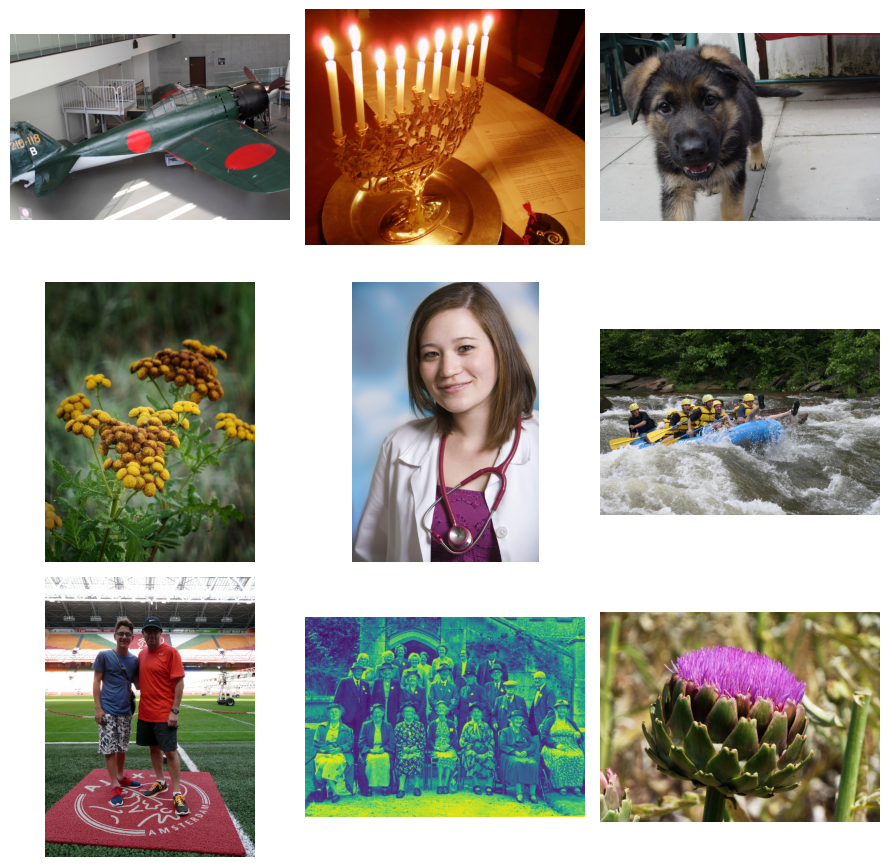

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_images_grid(folder_path):

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images = [Image.open(os.path.join(folder_path, img)) for img in image_files]
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

folder_path = "/root/fiftyone/open-images-v7/validation/data"
show_images_grid(folder_path)




---



#類似度の計算

In [ ]:
import os
import random
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = AutoModel.from_pretrained("facebook/dinov2-base")

def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze(0).detach().numpy()

def calculate_similarity(embedding1, embedding2):
    return cosine_similarity([embedding1], [embedding2])[0][0]

def display_images(image_path1, image_path2, similarity):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(Image.open(image_path1))
    axes[0].axis("off")

    axes[1].imshow(Image.open(image_path2))
    axes[1].axis("off")

    fig.text(0.5, 0.07, f"Cosine Similarity: {similarity:.4f}", ha='center', fontsize=12)
    plt.show()

def select_random_images(folder_path):
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp'))]
    return random.sample(image_files, 2)

def add_space():
    plt.figure(figsize=(1, 2))
    plt.axis("off")
    plt.show()

def main(folder_path):
    image_path1, image_path2 = select_random_images(folder_path)

    embedding1 = get_image_embedding(image_path1)
    similarity_same = calculate_similarity(embedding1, embedding1)
    display_images(image_path1, image_path1, similarity_same)

    add_space()

    embedding2 = get_image_embedding(image_path2)
    similarity_different = calculate_similarity(embedding1, embedding2)
    display_images(image_path1, image_path2, similarity_different)


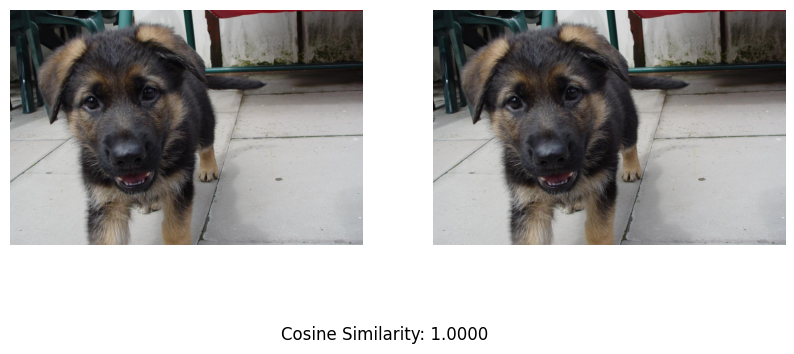

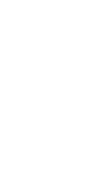

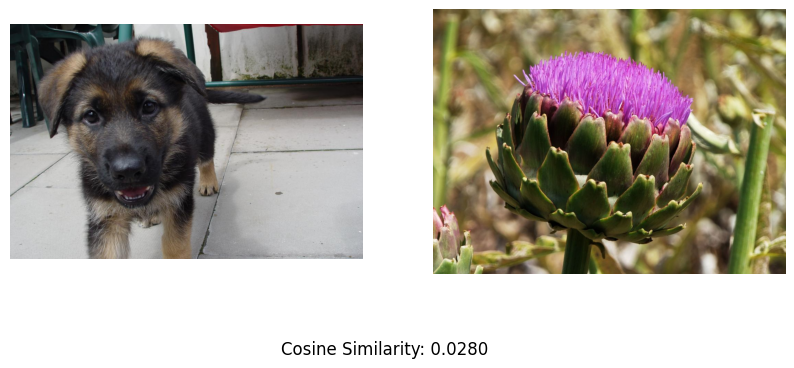

In [ ]:
folder_path = "/root/fiftyone/open-images-v7/validation/data"
main(folder_path)




---



# Matter.js

##Matter.jsは、JavaScriptで書かれた2Dのリジッドボディ（剛体）物理エンジンです。主にWeb上でのゲームやインタラクティブなアニメーション、シミュレーションの実装に利用されます。

## 1. 基本的な物理シミュレーション

剛体シミュレーション: 各オブジェクト（ボディ）が重力、摩擦、反発力などの物理法則に基づいて動作します。
衝突検出と反応: 自動的にオブジェクト同士の衝突を検出し、リアルな反応（バウンド、滑りなど）をシミュレーションします。
## 2. 柔軟なオブジェクトの生成

多様な形状: 長方形、円、多角形など、さまざまな形状のオブジェクトを作成可能です。
複合体（Composite）: 複数のボディを一つのグループにまとめることができ、複雑な構造物のシミュレーションが容易になります。
## 3. 制約とジョイント

オブジェクト同士を一定の距離や角度で結合する**制約（Constraint）**を設定することで、ロープやばね、リンクなどの物理的な接続をシミュレートできます。
## 4. イベントシステム

衝突開始、衝突終了、更新イベントなど、さまざまなタイミングでイベントを発生させることができ、インタラクションの処理や追加のアクションを実装できます。
## 5. レンダリングのサポート

内蔵のレンダラーを使って、HTML5のCanvas上に物理シミュレーションの結果を描画できます。また、他のレンダリングライブラリや自作の描画方法と組み合わせることも可能です。

<br>

###Matter.jsは、シンプルなセットアップで物理シミュレーションを開始できる反面、細かいパラメーターの調整ができるため、初心者から上級者まで幅広く利用されています。豊富なドキュメントとコミュニティサポートもあり、インタラクティブなWebアプリケーション開発に非常に有用なライブラリです。



---



#画像データ、データ保存先URL、埋め込みベクトルなどをS3, DynamoDBに保存

In [ ]:
!pip install boto3

In [ ]:
import boto3
import os
import json
import uuid
import glob
from PIL import Image
from datetime import datetime
from tqdm import tqdm
import torch
from transformers import AutoImageProcessor, AutoModel

# AWS 認証情報を設定
aws_access_key = "your_access_key"
aws_secret_key = "your_secret_key"


session = boto3.Session(
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    region_name="ap-northeast-1"
)

s3_client = session.client("s3")
dynamodb = session.resource("dynamodb")

# AWS Copilot で作成されたリソース
S3_BUCKET = "your_bucket_name"
DYNAMODB_TABLE = "your_table_name"
table = dynamodb.Table(DYNAMODB_TABLE)

# 画像フォルダのパス（Colab のローカルディレクトリ）
IMAGE_FOLDER = "/root/fiftyone/open-images-v7/validation/data"
THUMBNAIL_SIZE = (40, 40)  # サムネイルサイズ

# モデルのロード
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')


In [ ]:
def upload_to_s3(file_path, s3_key):
    """S3 に画像をアップロードし、URL を返す"""
    with open(file_path, "rb") as f:
        s3_client.put_object(Bucket=S3_BUCKET, Key=s3_key, Body=f, ContentType="image/jpeg")
    return f"https://{S3_BUCKET}.s3.ap-northeast-1.amazonaws.com/{s3_key}"

def process_and_upload_images():
    """画像を S3 にアップロードし、DynamoDB にメタデータを保存"""
    image_files = glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg"))
    if len(image_files) == 0:
        print("画像が見つかりません")
        return

    for file_path in tqdm(image_files, desc="画像アップロード中"):
        image_id = f"img_{uuid.uuid4().hex[:8]}"  # 一意の ID
        uploaded_at = datetime.utcnow().isoformat()  # タイムスタンプ

        # フルサイズ画像の S3 アップロード
        s3_fullsize_key = f"fullsize/{os.path.basename(file_path)}"
        s3_fullsize_url = upload_to_s3(file_path, s3_fullsize_key)

        # サムネイル画像の作成 & アップロード
        with Image.open(file_path) as img:
            img.thumbnail(THUMBNAIL_SIZE)
            thumbnail_path = f"/tmp/{os.path.basename(file_path)}"
            img.save(thumbnail_path, format="JPEG")

        s3_thumbnail_key = f"thumbnail/{os.path.basename(file_path)}"
        s3_thumbnail_url = upload_to_s3(thumbnail_path, s3_thumbnail_key)

        # 画像の埋め込みベクトルを計算
        image = Image.open(file_path)
        inputs = processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        embedding = last_hidden_states[:, 0, :].squeeze(0).tolist()  # `json.dumps()` 用にリスト化

        # DynamoDB に保存
        item = {
            "image_id": image_id,
            "s3_fullsize_url": s3_fullsize_url,
            "s3_thumbnail_url": s3_thumbnail_url,
            "embedding": json.dumps(embedding),  # 文字列として保存
            "uploaded_at": uploaded_at
        }
        table.put_item(Item=item)

    print(f"✅ アップロード完了: {len(image_files)} 枚")


In [ ]:
process_and_upload_images()